In [1]:
!pip install pyspark
!pip install findspark  
!pip install pandas
!pip install -U scikit-learn
!pip install -U matplotlib  
!pip install treeplot
!pip install graphviz
!pip install pydot

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
from pyspark.sql import SparkSession
import findspark
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import * 
from pyspark.sql.types import StringType,BooleanType,DateType, IntegerType  
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt
from pyspark.sql import SQLContext
from sklearn.metrics import confusion_matrix
from pyspark.conf import SparkConf
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn import metrics



findspark.init()

spark = SparkSession.builder.appName("Pyspark Tutorial")\
                    .config("spark.memory.offHeap.enabled","true")\
                    .config("spark.memory.offHeap.size","10g")\
                    .getOrCreate()


# check spark configuration

spark

23/01/23 11:00:40 WARN Utils: Your hostname, sepay-HP resolves to a loopback address: 127.0.1.1; using 192.168.1.31 instead (on interface wlo1)
23/01/23 11:00:40 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/01/23 11:00:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
!curl https://raw.githubusercontent.com/Sepay/Programming/main/obesity.csv >> obesity.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  257k  100  257k    0     0   411k      0 --:--:-- --:--:-- --:--:--  411k


In [4]:
df = spark.read.csv('obesity.csv',header=True,sep=",")

In [5]:
df.show(5,0)

+------+---+------+------+------------------------------+----+----+---+---------+-----+----+---+---+---+----------+---------------------+-------------------+
|Gender|Age|Height|Weight|family_history_with_overweight|FAVC|FCVC|NCP|CAEC     |SMOKE|CH2O|SCC|FAF|TUE|CALC      |MTRANS               |NObeyesdad         |
+------+---+------+------+------------------------------+----+----+---+---------+-----+----+---+---+---+----------+---------------------+-------------------+
|Female|21 |1.62  |64    |yes                           |no  |2   |3  |Sometimes|no   |2   |no |0  |1  |no        |Public_Transportation|Normal_Weight      |
|Female|21 |1.52  |56    |yes                           |no  |3   |3  |Sometimes|yes  |3   |yes|3  |0  |Sometimes |Public_Transportation|Normal_Weight      |
|Male  |23 |1.8   |77    |yes                           |no  |2   |3  |Sometimes|no   |2   |no |2  |1  |Frequently|Public_Transportation|Normal_Weight      |
|Male  |27 |1.8   |87    |no                        

In [6]:
df.count()

2111

In [9]:
df.groupBy("NObeyesdad").count().show()

+-------------------+-----+
|         NObeyesdad|count|
+-------------------+-----+
|   Obesity_Type_III|  324|
| Overweight_Level_I|  290|
|    Obesity_Type_II|  297|
|Insufficient_Weight|  272|
|Overweight_Level_II|  290|
|      Normal_Weight|  287|
|     Obesity_Type_I|  351|
+-------------------+-----+



In [10]:
df.filter((df["NObeyesdad"] == "Obesity_Type_I") | (df["NObeyesdad"] == "Obesity_Type_II") | (df["NObeyesdad"] == "Obesity_Type_III") ).count()

972

In [37]:
df.show()

+------+---+------+------+------------------------------+----+----+---+----------+-----+----+---+---+----------+--------------------+-------------------+
|Gender|Age|Height|Weight|family_history_with_overweight|FAVC|FCVC|NCP|      CAEC|SMOKE|CH2O|SCC|FAF|      CALC|              MTRANS|         NObeyesdad|
+------+---+------+------+------------------------------+----+----+---+----------+-----+----+---+---+----------+--------------------+-------------------+
|Female| 21|  1.62|    64|                           yes|  no|   2|  3| Sometimes|   no|   2| no|  0|        no|Public_Transporta...|      Normal_Weight|
|Female| 21|  1.52|    56|                           yes|  no|   3|  3| Sometimes|  yes|   3|yes|  3| Sometimes|Public_Transporta...|      Normal_Weight|
|  Male| 23|   1.8|    77|                           yes|  no|   2|  3| Sometimes|   no|   2| no|  2|Frequently|Public_Transporta...|      Normal_Weight|
|  Male| 27|   1.8|    87|                            no|  no|   3|  3| Some

# Variáveis

Retirou-se a coluna dos telemoveis 

# TRATAMENTO DE DADOS

Alterou-se as colunas Gender, FH, CAEC, SMOLE, SCC, CALC, MTRANS, OBESITY para inteiros para ser mais facil executar os algoritmos


In [13]:
df.groupBy('NObeyesdad').count().show()

+-------------------+-----+
|         NObeyesdad|count|
+-------------------+-----+
|   Obesity_Type_III|  324|
| Overweight_Level_I|  290|
|    Obesity_Type_II|  297|
|Insufficient_Weight|  272|
|Overweight_Level_II|  290|
|      Normal_Weight|  287|
|     Obesity_Type_I|  351|
+-------------------+-----+



In [14]:
df = df.withColumn("CAEC", when(col("CAEC")== "Sometimes", 0).when(col("CAEC") == "Frequently", 1).otherwise(2))
df = df.withColumn("Gender", when(col("Gender")== "Female", 0).otherwise(1))
df = df.withColumn("family_history_with_overweight", when(col("family_history_with_overweight")== "yes", 0).otherwise(1))
df = df.withColumn("FAVC", when(col("FAVC")== "yes", 0).otherwise(1))
df = df.withColumn("SMOKE", when(col("SMOKE")== "yes", 0).otherwise(1))
df = df.withColumn("SCC", when(col("SCC")== "yes", 0).otherwise(1))
df = df.withColumn("CALC", when(col("CALC")== "no", 0).when(col("CALC") == "Sometimes", 1).when(col("CALC")=="Frequently", 2).otherwise(3))
df = df.withColumn("MTRANS", when(col("MTRANS")== "Public_Transportation", 0).when(col("MTRANS") == "Automobile", 0).when(col("MTRANS")=="Motorbike", 0).otherwise(1))

In [15]:
df=df.withColumnRenamed("family_history_with_overweight","FH")
df=df.withColumnRenamed('FAVC','CALORICFOOD')
df=df.withColumnRenamed('Gender','GENDER')
df=df.withColumnRenamed('Age','AGE')
df=df.withColumnRenamed('Weight','WEIGHT')
df=df.withColumnRenamed('Height','HEIGHT')
df=df.withColumnRenamed('FCVC','VEGET')
df=df.withColumnRenamed('NCP','MEALS')
df=df.withColumnRenamed('CAEC','BETWEENMEALS')
df=df.withColumnRenamed('CH2O','H20')
df=df.withColumnRenamed('SCC','CALORIES')
df=df.withColumnRenamed('FAF','PHYSY')
df=df.withColumnRenamed('CALC','ALCH')
df=df.withColumnRenamed('MTRANS','TRANSPORT')
df=df.withColumnRenamed('NObeyesdad','OBESITY')

In [16]:
df.show()

+------+---+------+------+---+-----------+-----+-----+------------+-----+---+--------+-----+---+----+---------+-------------------+
|GENDER|AGE|HEIGHT|WEIGHT| FH|CALORICFOOD|VEGET|MEALS|BETWEENMEALS|SMOKE|H20|CALORIES|PHYSY|TUE|ALCH|TRANSPORT|            OBESITY|
+------+---+------+------+---+-----------+-----+-----+------------+-----+---+--------+-----+---+----+---------+-------------------+
|     0| 21|  1.62|    64|  0|          1|    2|    3|           0|    1|  2|       1|    0|  1|   0|        0|      Normal_Weight|
|     0| 21|  1.52|    56|  0|          1|    3|    3|           0|    0|  3|       0|    3|  0|   1|        0|      Normal_Weight|
|     1| 23|   1.8|    77|  0|          1|    2|    3|           0|    1|  2|       1|    2|  1|   2|        0|      Normal_Weight|
|     1| 27|   1.8|    87|  1|          1|    3|    3|           0|    1|  2|       1|    2|  0|   2|        1| Overweight_Level_I|
|     1| 22|  1.78|  89.8|  1|          1|    2|    1|           0|    1|  2

LOGISTIC REGRESSION

In [17]:
df = df.withColumn("OBESITY", when(col("OBESITY")== "Insufficient_Weight", 0).when(col("OBESITY") == "Normal_Weight", 0).when(col("OBESITY")=="Overweight_Level_I", 0).when(col("OBESITY")== "Overweight_Level_II",0).otherwise(1))


Converter tudo para int

In [18]:
df = df.withColumn("VEGET",col("VEGET").cast(IntegerType())) \
    .withColumn("MEALS",col("MEALS").cast(IntegerType())) \
    .withColumn("H20",col("H20").cast(IntegerType())) \
    .withColumn("PHYSY",col("PHYSY").cast(IntegerType()))\
    .withColumn("WEIGHT",col("WEIGHT").cast(IntegerType()))
df = df.dropna()
df.printSchema()

root
 |-- GENDER: integer (nullable = false)
 |-- AGE: string (nullable = true)
 |-- HEIGHT: string (nullable = true)
 |-- WEIGHT: integer (nullable = true)
 |-- FH: integer (nullable = false)
 |-- CALORICFOOD: integer (nullable = false)
 |-- VEGET: integer (nullable = true)
 |-- MEALS: integer (nullable = true)
 |-- BETWEENMEALS: integer (nullable = false)
 |-- SMOKE: integer (nullable = false)
 |-- H20: integer (nullable = true)
 |-- CALORIES: integer (nullable = false)
 |-- PHYSY: integer (nullable = true)
 |-- TUE: string (nullable = true)
 |-- ALCH: integer (nullable = false)
 |-- TRANSPORT: integer (nullable = false)
 |-- OBESITY: integer (nullable = false)



In [19]:

assemble=VectorAssembler(inputCols=[
    'FH','CALORICFOOD', "SMOKE", "VEGET", "MEALS", 
    "BETWEENMEALS", "H20", "CALORIES", "PHYSY", "ALCH", "WEIGHT"
], outputCol='features')

In [20]:
assembled_data=assemble.transform(df)

In [21]:
scale=StandardScaler(inputCol='features',outputCol='standardized')
scale=scale.fit(assembled_data)
scale_output= scale.transform(assembled_data)

scale_output.select('standardized').show(2,truncate=False)


+-------------------------------------------------------------------------------------------------------------------------------------------------+
|standardized                                                                                                                                     |
+-------------------------------------------------------------------------------------------------------------------------------------------------+
|[0.0,3.121378843400082,6.9982389606829125,3.336686863221176,3.613202391046148,0.0,3.3402391915605234,4.798574066183805,0.0,0.0,2.453544677510144]|
|[0.0,3.121378843400082,0.0,5.005030294831764,3.613202391046148,0.0,5.010358787340785,0.0,3.6022537948268702,1.9398714852505572,2.146851592821376]|
+-------------------------------------------------------------------------------------------------------------------------------------------------+
only showing top 2 rows



In [22]:
finalData = scale_output.select("standardized", "OBESITY")
train, test =finalData.randomSplit([0.8,0.2])

In [24]:

lr = LogisticRegression(featuresCol="standardized" ,labelCol="OBESITY", maxIter=5)
lrModel = lr.fit(train)

In [28]:
predictions = lrModel.transform(test)
predictions.select("OBESITY", "standardized", "rawPrediction", "prediction", "probability").toPandas().head(5)

,OBESITY,standardized,rawPrediction,prediction,probability
0,1,"(0.0, 0.0, 6.9982389606829125, 1.6683434316105...","[1.2088432476496855, -1.2088432476496855]",0.0,"[0.7700942110537649, 0.22990578894623515]"
1,1,"(0.0, 0.0, 6.9982389606829125, 1.6683434316105...","[-0.3379072295971426, 0.3379072295971426]",1.0,"[0.41631792541496515, 0.5836820745850348]"
2,1,"(0.0, 0.0, 6.9982389606829125, 1.6683434316105...","[-0.49474762231005265, 0.49474762231005265]",1.0,"[0.37877578864605366, 0.6212242113539463]"
3,1,"(0.0, 0.0, 6.9982389606829125, 1.6683434316105...","[-3.4747150838553544, 3.4747150838553544]",1.0,"[0.03004028912739876, 0.9699597108726012]"
4,0,"(0.0, 0.0, 6.9982389606829125, 1.6683434316105...","[1.2337657222689558, -1.2337657222689558]",0.0,"[0.7744769840600266, 0.22552301593997337]"


In [29]:

eval = BinaryClassificationEvaluator(rawPredictionCol = "prediction", labelCol = "OBESITY")
auc = eval.evaluate(predictions)
print(auc)

0.8894584529791817


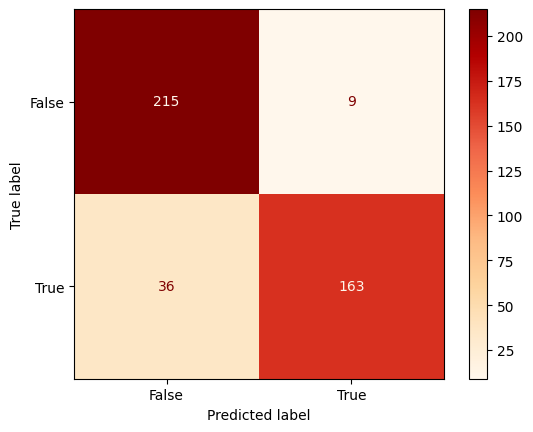

In [31]:
from sklearn import metrics
y_true = predictions.select("OBESITY")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnfMatrix = confusion_matrix(y_true, y_pred)


cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cnfMatrix, display_labels = [False, True])
cm_display.plot(cmap = "OrRd")
plt.show() 

In [32]:
FP = predictions.where(predictions["OBESITY"] == predictions["prediction"]).count()
accuracy = FP /float(predictions.count())
accuracy

0.8936170212765957

Text(0, 0.5, 'True Positive Rate')

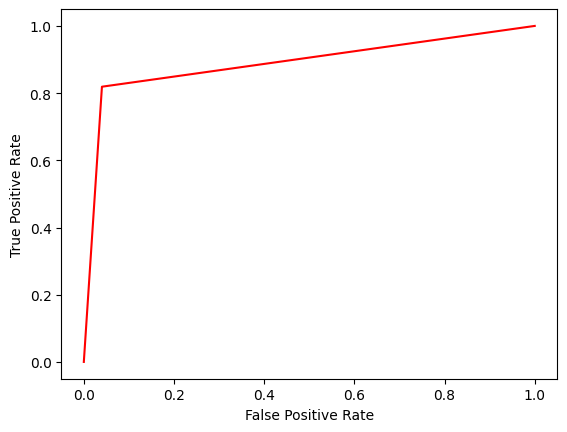

In [33]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, threshold = roc_curve(y_true, y_pred)
plt.plot(fpr, tpr, color="red")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [34]:
paramGrid = ParamGridBuilder()\
            .addGrid(lr.regParam, [0.01,0.5,2.0])\
            .addGrid(lr.elasticNetParam, [0.0,0.5,1.0])\
            .addGrid(lr.maxIter, [1,5,10])\
            .build()


In [35]:
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid,
                    evaluator=eval, numFolds=5 , parallelism=4)

In [36]:
cvModel = cv.fit(train)

23/01/22 17:30:34 WARN BlockManager: Block rdd_172_0 already exists on this machine; not re-adding it


In [37]:
predictions_cv = cvModel.transform(test)
eval.evaluate(predictions_cv)

0.8958856783919598

In [38]:
FP = predictions_cv.where(predictions_cv["OBESITY"] == predictions_cv["prediction"]).count()
accuracy = FP /float(predictions_cv.count())
accuracy

0.8983451536643026

## KMEANS CLUSTERING MODEL

### Decision trees

In [22]:
df_knn = spark.read.csv('obesity.csv',header=True,sep=",")
df_knn.show()

+------+---+------+------+------------------------------+----+----+---+----------+-----+----+---+---+---+----------+--------------------+-------------------+
|Gender|Age|Height|Weight|family_history_with_overweight|FAVC|FCVC|NCP|      CAEC|SMOKE|CH2O|SCC|FAF|TUE|      CALC|              MTRANS|         NObeyesdad|
+------+---+------+------+------------------------------+----+----+---+----------+-----+----+---+---+---+----------+--------------------+-------------------+
|Female| 21|  1.62|    64|                           yes|  no|   2|  3| Sometimes|   no|   2| no|  0|  1|        no|Public_Transporta...|      Normal_Weight|
|Female| 21|  1.52|    56|                           yes|  no|   3|  3| Sometimes|  yes|   3|yes|  3|  0| Sometimes|Public_Transporta...|      Normal_Weight|
|  Male| 23|   1.8|    77|                           yes|  no|   2|  3| Sometimes|   no|   2| no|  2|  1|Frequently|Public_Transporta...|      Normal_Weight|
|  Male| 27|   1.8|    87|                          

In [23]:
df_knn = df_knn.drop('TUE')
df_knn = df_knn.withColumn("CAEC", when(col("CAEC")== "Sometimes", 0).when(col("CAEC") == "Frequently", 1).otherwise(2))
df_knn = df_knn.withColumn("Gender", when(col("Gender")== "Female", 0).otherwise(1))
df_knn = df_knn.withColumn("family_history_with_overweight", when(col("family_history_with_overweight")== "yes", 0).otherwise(1))
df_knn = df_knn.withColumn("FAVC", when(col("FAVC")== "yes", 0).otherwise(1))
df_knn = df_knn.withColumn("SMOKE", when(col("SMOKE")== "yes", 0).otherwise(1))
df_knn = df_knn.withColumn("SCC", when(col("SCC")== "yes", 0).otherwise(1))
df_knn = df_knn.withColumn("CALC", when(col("CALC")== "no", 0).when(col("CALC") == "Sometimes", 1).when(col("CALC")=="Frequently", 2).otherwise(3))
df_knn = df_knn.withColumn("MTRANS", when(col("MTRANS")== "Public_Transportation", 0).when(col("MTRANS") == "Automobile", 0).when(col("MTRANS")=="Motorbike", 0).otherwise(1))
df_knn = df_knn.withColumn("NObeyesdad", when(col("NObeyesdad")== "Insufficient_Weight", 1).when(col("NObeyesdad") == "Normal_Weight", 2).when(col("NObeyesdad")=="Overweight_Level_I", 3).when(col("NObeyesdad")== "Overweight_Level_II",4).when(col("NObeyesdad")=="Obesity_Type_I", 5).otherwise(6))

In [24]:
df_knn=df_knn.withColumnRenamed("family_history_with_overweight","FH")
df_knn=df_knn.withColumnRenamed('FAVC','CALORICFOOD')
df_knn=df_knn.withColumnRenamed('Gender','GENDER')
df_knn=df_knn.withColumnRenamed('Age','AGE')
df_knn=df_knn.withColumnRenamed('Weight','WEIGHT')
df_knn=df_knn.withColumnRenamed('Height','HEIGHT')
df_knn=df_knn.withColumnRenamed('FCVC','VEGET')
df_knn=df_knn.withColumnRenamed('NCP','MEALS')
df_knn=df_knn.withColumnRenamed('CAEC','BETWEENMEALS')
df_knn=df_knn.withColumnRenamed('CH2O','H20')
df_knn=df_knn.withColumnRenamed('SCC','CALORIES')
df_knn=df_knn.withColumnRenamed('FAF','PHYSY')
df_knn=df_knn.withColumnRenamed('CALC','ALCH')
df_knn=df_knn.withColumnRenamed('MTRANS','TRANSPORT')
df_knn=df_knn.withColumnRenamed('NObeyesdad','OBESITY')

In [25]:
df_knn = df_knn.withColumn("VEGET",col("VEGET").cast(IntegerType())) \
    .withColumn("MEALS",col("MEALS").cast(IntegerType())) \
    .withColumn("H20",col("H20").cast(IntegerType())) \
    .withColumn("PHYSY",col("PHYSY").cast(IntegerType()))\
    .withColumn("AGE",col("AGE").cast(IntegerType()))\
    .withColumn("WEIGHT",col("WEIGHT").cast(IntegerType()))
df_knn = df_knn.dropna()
df_knn.printSchema()

root
 |-- GENDER: integer (nullable = false)
 |-- AGE: integer (nullable = true)
 |-- HEIGHT: string (nullable = true)
 |-- WEIGHT: integer (nullable = true)
 |-- FH: integer (nullable = false)
 |-- CALORICFOOD: integer (nullable = false)
 |-- VEGET: integer (nullable = true)
 |-- MEALS: integer (nullable = true)
 |-- BETWEENMEALS: integer (nullable = false)
 |-- SMOKE: integer (nullable = false)
 |-- H20: integer (nullable = true)
 |-- CALORIES: integer (nullable = false)
 |-- PHYSY: integer (nullable = true)
 |-- ALCH: integer (nullable = false)
 |-- TRANSPORT: integer (nullable = false)
 |-- OBESITY: integer (nullable = false)



In [26]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [27]:
assembleTree=VectorAssembler(inputCols=[
    'FH','CALORICFOOD', "SMOKE",
    "VEGET", "MEALS", "BETWEENMEALS",
    "H20", "CALORIES", "PHYSY",
    "ALCH", "GENDER", "AGE",
    "WEIGHT"
], outputCol='features')

In [28]:
assembledTree_data=assembleTree.transform(df_knn)

In [41]:
scale=StandardScaler(inputCol='features',outputCol='standardized')
scale=scale.fit(assembledTree_data)
scale_outputTree= scale.transform(assembledTree_data)

scale_outputTree.select('standardized').show(2,truncate=False)

finalDataTree = scale_outputTree.select("standardized", "OBESITY")
trainT, testT =finalDataTree.randomSplit([0.8,0.2])

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|standardized                                                                                                                                                            |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[0.0,3.121378843400082,6.9982389606829125,3.336686863221176,3.613202391046148,0.0,3.3402391915605234,4.798574066183805,0.0,0.0,0.0,3.3287553641811694,2.453544677510144]|
|[0.0,3.121378843400082,0.0,5.005030294831764,3.613202391046148,0.0,5.010358787340785,0.0,3.6022537948268702,1.9398714852505572,0.0,3.3287553641811694,2.146851592821376]|
+------------------------------------------------------------------------------------------------------------------------------------------------

In [42]:
deciTree = DecisionTreeClassifier(featuresCol="standardized", labelCol="OBESITY", maxDepth=4)
deciTree = deciTree.fit(trainT)

predTree = deciTree.transform(testT)
predTree.show()

+--------------------+-------+--------------------+--------------------+----------+
|        standardized|OBESITY|       rawPrediction|         probability|prediction|
+--------------------+-------+--------------------+--------------------+----------+
|(13,[2,3,4,6,7,11...|      5|[0.0,0.0,0.0,17.0...|[0.0,0.0,0.0,0.10...|       5.0|
|(13,[2,3,4,6,7,11...|      3|[0.0,10.0,83.0,12...|[0.0,0.0401606425...|       3.0|
|(13,[2,3,4,6,7,11...|      3|[0.0,10.0,83.0,12...|[0.0,0.0401606425...|       3.0|
|(13,[2,3,4,6,7,11...|      2|[0.0,6.0,33.0,7.0...|[0.0,0.1304347826...|       2.0|
|(13,[2,3,4,6,7,11...|      4|[0.0,10.0,83.0,12...|[0.0,0.0401606425...|       3.0|
|(13,[2,3,4,6,7,11...|      5|[0.0,0.0,0.0,17.0...|[0.0,0.0,0.0,0.10...|       5.0|
|(13,[2,3,4,6,7,11...|      5|[0.0,0.0,0.0,17.0...|[0.0,0.0,0.0,0.10...|       5.0|
|(13,[2,3,4,6,7,11...|      4|[0.0,0.0,0.0,17.0...|[0.0,0.0,0.0,0.10...|       5.0|
|(13,[2,3,4,6,7,11...|      4|[0.0,0.0,0.0,17.0...|[0.0,0.0,0.0,0.10...|    

In [43]:
evaluator=MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="OBESITY")
acc = evaluator.evaluate(predTree)
print(acc)

0.7194144570622878


In [44]:
y_pred=predTree.select("prediction").collect()
y_orig=predTree.select("OBESITY").collect()

In [45]:

cmTree = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cmTree)


Confusion Matrix:
[[ 51   3   2   0   0   0]
 [ 12  20  25   5   0   0]
 [  1   5  42  16   7   0]
 [  0   9   1  35  15   0]
 [  0   0   1  14  34   1]
 [  0   0   0   1   0 132]]


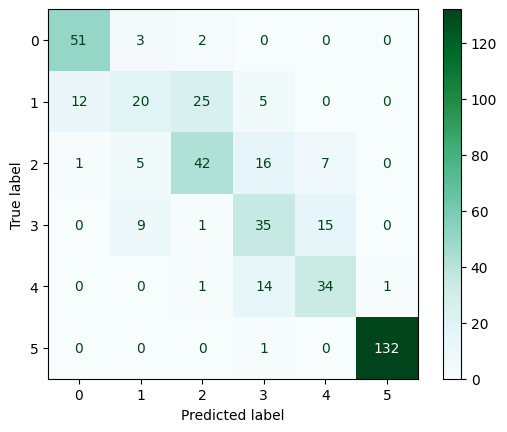

In [46]:
#Desenhar a matriz


cmTree_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cmTree)
cmTree_display.plot(cmap = "BuGn")